In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

In [2]:
using Plots
using LaTeXStrings

In [3]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = cylinder_state_to_lagrange(state, config)
    Z = X .+ im*Y'
    ψ = imag.(LowRankVortex.F(Z, source))
    
    plt = plot(collect(X), collect(Y), ψ', ratio = 1.0, colorbar = false, 
                      xlim = (X[1], X[end]), 
                      ylim = (Y[1], Y[end]); levels = 10)
    
        
    θc = range(0,2π,length=201)
    zc = exp.(im*θc[1:end-1])
    plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
    
    if withvortices == true
        plot!(plt, source, markersize = 4, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

routine_plot (generic function with 1 method)

In [27]:
## Validation with one vortex of strength 1

zJ = 1.1*exp(im*0.0)
ΓJ = 2*π
blobs = map(Vortex.Point, [zJ], [ΓJ])

@show conjwJ = conj(ΓJ/(2*π*im)*(-1/(zJ -1/conj(zJ)) + 1/zJ))

@show conj(LowRankVortex.w(blobs[1].z, blobs; ϵ = config_data.δ))

@show conj((-ΓJ)/(2*π*im)*inv(zJ*(abs2(zJ)-1)))

conjwJ = conj((ΓJ / (2 * π * im)) * (-1 / (zJ - 1 / conj(zJ)) + 1 / zJ)) = 0.0 - 4.329004329004325im
conj(LowRankVortex.w((blobs[1]).z, blobs; ϵ = config_data.δ)) = 0.0 - 4.329004329004325im
conj((-ΓJ / (2 * π * im)) * inv(zJ * (abs2(zJ) - 1))) = 0.0 - 4.3290043290043245im


0.0 - 4.3290043290043245im

## Create set of point blobs

In [5]:
# grid for evaluation
xgrid = range(-4,4,length=201)
ygrid = copy(xgrid)
zgrid = xgrid .+ im*ygrid';

# sensors on the unit circle
θsensors = range(0,2π,length=501)[1:end-1]
sensors = exp.(im*θsensors)

# create configuration file
config_data = let Nv = 8, U = complex(0.0), 
             ss = sensors, Δt = 5e-3, δ = 1e-3,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

VortexConfig(8, 0.0 + 0.0im, ComplexF64[1.0 + 0.0im, 0.9999210442038161 + 0.012566039883352607im, 0.9996841892832999 + 0.02513009544333748im, 0.9992894726405892 + 0.03769018266993454im, 0.9987369566060175 + 0.050244318179769556im, 0.9980267284282716 + 0.06279051952931337im, 0.9971589002606139 + 0.07532680552793272im, 0.9961336091431725 + 0.08785119655074318im, 0.9949510169813002 + 0.1003617148512149im, 0.9936113105200084 + 0.11285638487348168im  …  0.9921147013144779 - 0.1253332335643038im, 0.9936113105200085 - 0.11285638487348111im, 0.9949510169813002 - 0.10036171485121509im, 0.9961336091431725 - 0.08785119655074328im, 0.9971589002606139 - 0.07532680552793272im, 0.9980267284282716 - 0.06279051952931326im, 0.9987369566060175 - 0.05024431817976934im, 0.9992894726405892 - 0.037690182669934215im, 0.9996841892832999 - 0.02513009544333705im, 0.9999210442038161 - 0.012566039883352071im], 0.005, 0.001, 0.0001, 0.0001, 1.0, 0.01)

In [6]:
 #blobs = create_random_vortices(config_data.Nv; σ=config_data.δ)
θv = range(0,2π,length=config_data.Nv+1)[1:end-1]
rv = 2.0
zv = rv*exp.(im*θv)
Γv = 10#*(-1).^(0:config_data.Nv-1)

blobs = Vortex.Blob.(zv,Γv,config_data.δ*ones(config_data.Nv))
#blobs = vcat(blobs, Vortex.Blob.(2zv*exp.(im*π/4),Γv,config_data.δ*ones(config_data.Nv)))

8-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(2.0 + 0.0im, 10.0, 0.001)
 Vortex.Blob(1.4142135623730951 + 1.414213562373095im, 10.0, 0.001)
 Vortex.Blob(1.2246467991473532e-16 + 2.0im, 10.0, 0.001)
 Vortex.Blob(-1.414213562373095 + 1.4142135623730951im, 10.0, 0.001)
 Vortex.Blob(-2.0 + 2.4492935982947064e-16im, 10.0, 0.001)
 Vortex.Blob(-1.4142135623730954 - 1.414213562373095im, 10.0, 0.001)
 Vortex.Blob(-3.6739403974420594e-16 - 2.0im, 10.0, 0.001)
 Vortex.Blob(1.4142135623730947 - 1.4142135623730954im, 10.0, 0.001)

## Create state representation

In [7]:
Ne = 1
Ny = length(config_data.ss)
Nx = 3*config_data.Nv

X0 = zeros(Ny+Nx, Ne)

X0[Ny+1:Ny+Nx,1] .= cylinder_lagrange_to_state(blobs, config_data)

X = deepcopy(X0);

In [8]:
### Time marching of the vortices

In [9]:
t0 = 0.0
tf = 1.0

n0 = ceil(Int64, t0/config_data.Δt) + 1
J = (tf-t0)/config_data.Δt
Acycle = n0:n0+J-1


cachevels = allocate_velocity(blobs)
Xf = Array{Float64,2}[]
push!(Xf, copy(state(X0, Ny, Nx)))

t = 0.0
for i=1:length(Acycle)
    t += config_data.Δt
    X, _ = cylinder_vortex(X, 0.0, Ny, Nx, cachevels, config_data)
    push!(Xf, deepcopy(state(X, Ny, Nx)))
end

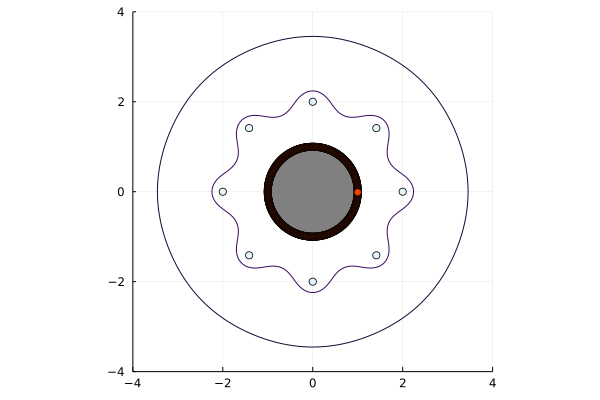

In [10]:
routine_plot(mean(Xf[1]; dims = 2)[:,1], config_data, xgrid, ygrid)

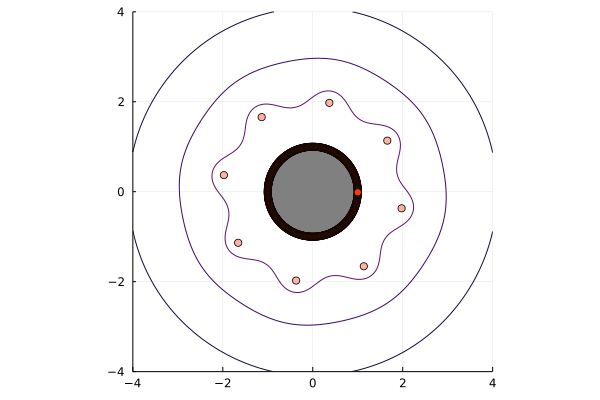

In [11]:
routine_plot(mean(Xf[end]; dims = 2)[:,1], config_data, xgrid, ygrid)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
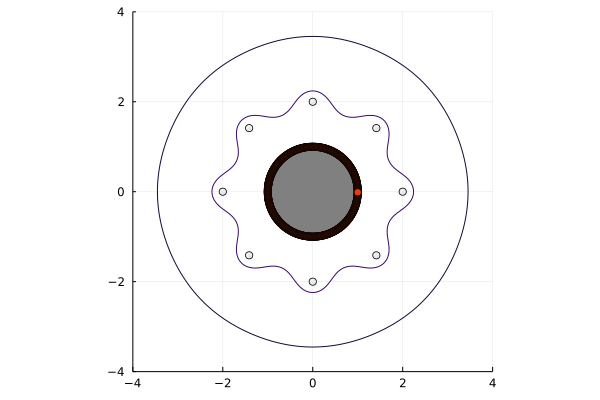

In [12]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(mean(Xf[nsnap]; dims = 2)[:,1], config_data, xgrid, ygrid)
    next!(prog)
end

In [40]:
J = zeros(length(config_data.ss), Nx)

@time for i=1:config_data.Nv
    dpdzi = dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data); ϵ = config_data.δ)
    J[:,3*i-2] .= 2*real(dpdzi)  
    J[:,3*i-1] .= -2*imag(dpdzi)
    
    dpdΓi = dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))
    J[:,3*i] .= dpdΓi
end

  0.122046 seconds (182.22 k allocations: 10.025 MiB, 68.60% compilation time)


In [14]:
U, Λ, V = svd(J);

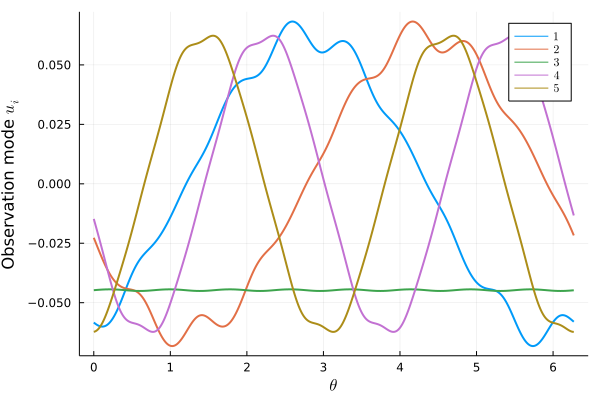

In [28]:
plt = plot(xlabel = L"\theta", ylabel = "Observation mode "*L"u_i")

for i=1:5
    plot!(plt, θsensors, U[:,i], linewidth = 2, label = latexstring(i))
end
#scatter!(plt, θsensors, zero(θsensors), markersize = 5)

plt

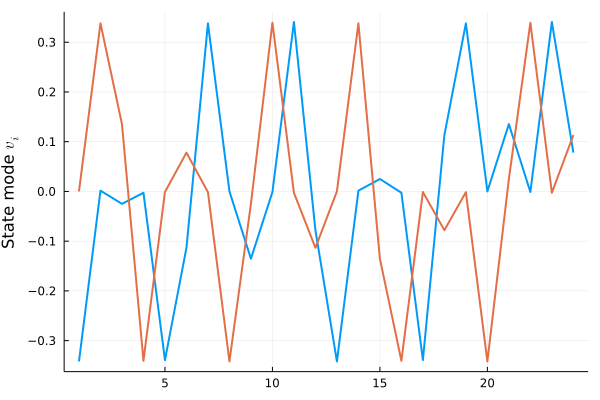

In [31]:
plt = plot(ylabel = "State mode "*L"v_i", legend = false)

for i=1:2
    plot!(plt, V[:,i], linewidth = 2)
end
plt

In [32]:
Cy = J*J'
Λy = sqrt.(svd(Cy).S)
cumsum((Λy.^2)./sum(Λy.^2))

500-element Vector{Float64}:
 0.22816348824488816
 0.45632697648977577
 0.6704912288390016
 0.7687093070930963
 0.8669273853471903
 0.9171421839348132
 0.9673569825224361
 0.9817055280593932
 0.9942820795381175
 0.9959989758885006
 0.9977158722388837
 0.9985156885775845
 0.9993155049162853
 ⋮
 0.9999999999999987
 0.9999999999999987
 0.9999999999999987
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999989
 0.9999999999999989
 0.9999999999999989

In [33]:
Cx = J'*J
Λx = sqrt.(svd(Cx).S)
cumsum((Λx.^2)./sum(Λx.^2))

24-element Vector{Float64}:
 0.2281634882448905
 0.4563269764897807
 0.6704912288390086
 0.7687093070931043
 0.8669273853471992
 0.9171421839348226
 0.9673569825224461
 0.9817055280594033
 0.9942820795381277
 0.9959989758885108
 0.9977158722388939
 0.9985156885775948
 0.9993155049162955
 0.9995853205303453
 0.999855136144395
 0.9998956660044431
 0.9999357895462438
 0.9999486468847354
 0.9999615042232269
 0.9999704197867598
 0.9999793353502927
 0.9999868068469013
 0.9999934034234506
 0.9999999999999998

In [34]:
(cumsum(Λ.^2)./sum(Λ.^2))

24-element Vector{Float64}:
 0.22816348824489047
 0.4563269764897805
 0.6704912288390087
 0.7687093070931044
 0.8669273853471993
 0.9171421839348227
 0.9673569825224462
 0.9817055280594033
 0.9942820795381277
 0.9959989758885108
 0.9977158722388939
 0.9985156885775948
 0.9993155049162955
 0.9995853205303452
 0.9998551361443949
 0.999895666004443
 0.9999357895462438
 0.9999486468847354
 0.9999615042232268
 0.9999704197867597
 0.9999793353502926
 0.9999868068469013
 0.9999934034234506
 0.9999999999999999

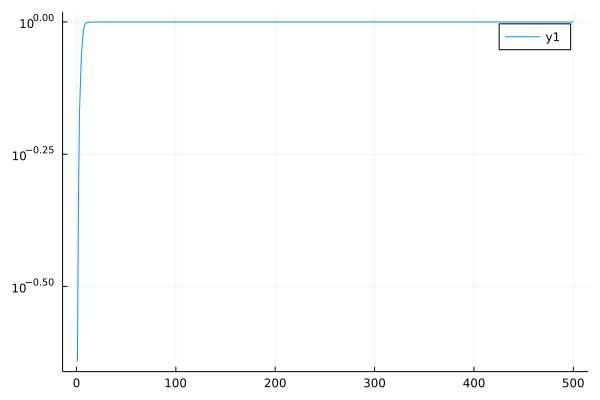

In [35]:
plot(cumsum(Λy.^2)./sum(Λy.^2), yscale = :log10)

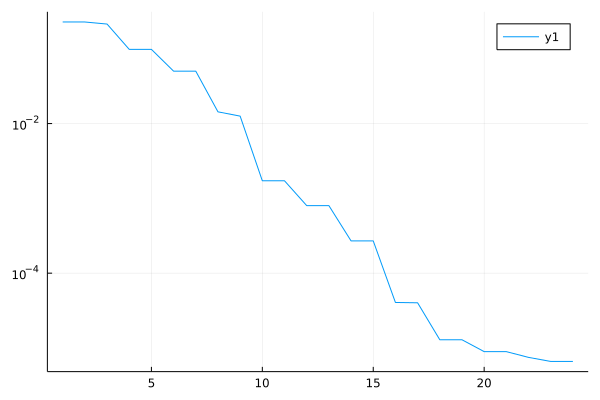

In [36]:
plot((Λ.^2)./sum(Λ.^2), yscale = :log10)

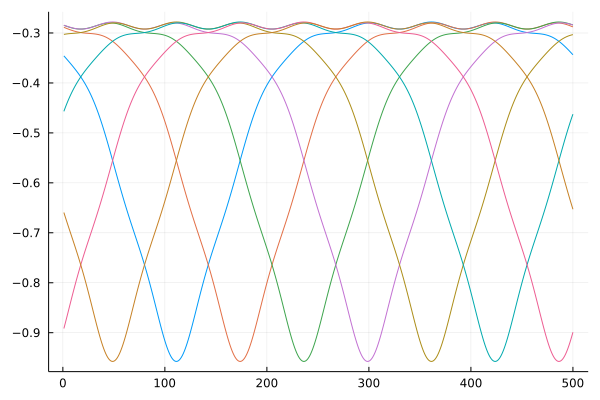

In [37]:
plt = plot(legend = false)

for i=1:config_data.Nv
    #plot!(plt, real(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    #plot!(plt, imag(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    plot!(plt, dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data)))
end
plt

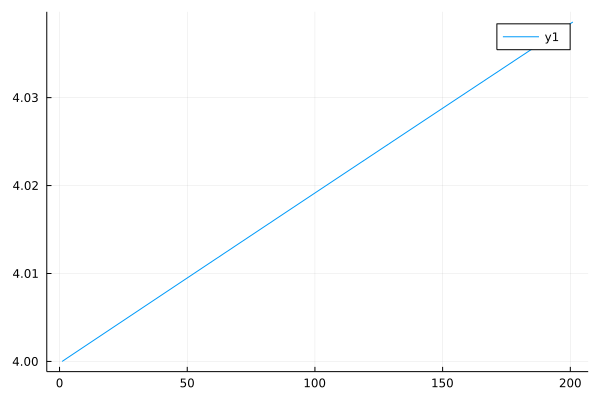

In [23]:
plot(map(xi -> xi[1]^2 + xi[2]^2, Xf))

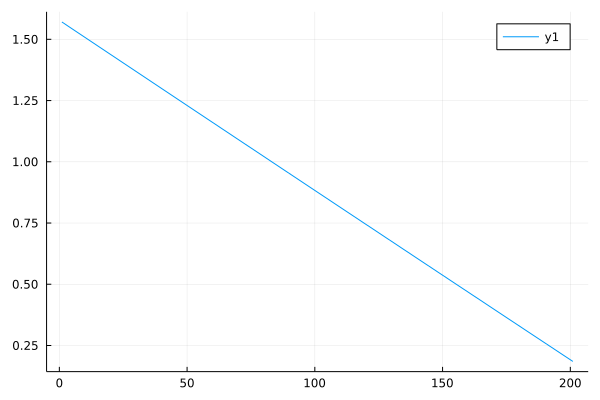

In [24]:
plot(map(xi -> atan(xi[1], xi[2]), Xf))

In [25]:
-ΓJ/(4*π^2*(abs2(zJ)*(abs2(zJ)-1)))

-0.626347670570229

In [26]:
10-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.5524030608054593 + 1.4966356498690878im, 1.777087057229044, 1.0e-7)
 Vortex.Blob(0.30297956811366955 - 1.5310233453394266im, 2.9950386389152985, 1.0e-7)
 Vortex.Blob(1.9533834668703678 + 1.5266552994597413im, 1.2339447083625958, 1.0e-7)
 Vortex.Blob(-1.0513133042403213 - 1.8227794557170132im, 1.6223707566499805, 1.0e-7)
 Vortex.Blob(-1.0836095985941654 + 0.7843079480127662im, 1.2450142628958365, 1.0e-7)
 Vortex.Blob(1.3467972420595151 + 0.7119955880276292im, 2.3945872015751033, 1.0e-7)
 Vortex.Blob(-1.543405087720262 - 0.948819867733115im, 2.391208846205823, 1.0e-7)
 Vortex.Blob(1.7504807284205954 - 1.4213977275321987im, 1.3496791100069796, 1.0e-7)
 Vortex.Blob(-1.2616569955408155 + 0.3668878315302502im, 1.7170363502434927, 1.0e-7)
 Vortex.Blob(0.9089535560506601 - 1.9950164010242206im, 1.6791417364879595, 1.0e-7)

LoadError: syntax: extra token "Vector" after end of expression